# Notes

# Load Modules

In [1]:
import moscot as mt
import moscot.plotting as mtp
from moscot import datasets
from moscot.problems.spatiotemporal import SpatioTemporalProblem

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scanpy as sc
import squidpy as sq
import anndata as ad

# E12.5 -> E14.5

In [2]:
samples = ['E12_E1S3','E14_E1S3']
adata_list = []
for i in samples:
    counts = pd.read_csv('../../../source/Moscot/ss0_'+str(i)+'_GEraw.csv',index_col=0)
    coords = pd.read_csv('../../../source/Moscot/ss0_'+str(i)+'_loc.csv',index_col=0)
    meta = pd.read_csv('../../../source/Moscot/ss0_'+str(i)+'_meta.csv',index_col=0)
    adata = sc.AnnData(X = counts, obs = meta, obsm = {'spatial': coords.to_numpy()})
    adata.layers['counts'] = adata.X
    adata.obs['sample'] = pd.Categorical(adata.obs['sample'])
    adata_list.append(adata)

In [3]:
# merge into one anndata
import anndata as ad
adata_e12_14 = ad.concat(
    {"E12_E1S3": adata_list[0], "E14_E1S3": adata_list[1]},
    label="library_id"
)

In [4]:
timepoint = [float(item.split('E')[1])+0.5 for item in adata_e12_14.obs.timepoint.values]
adata_e12_14.obs['time'] = timepoint
adata_e12_14.obs['time'].value_counts()

time
12.5    3679
14.5    3664
Name: count, dtype: int64

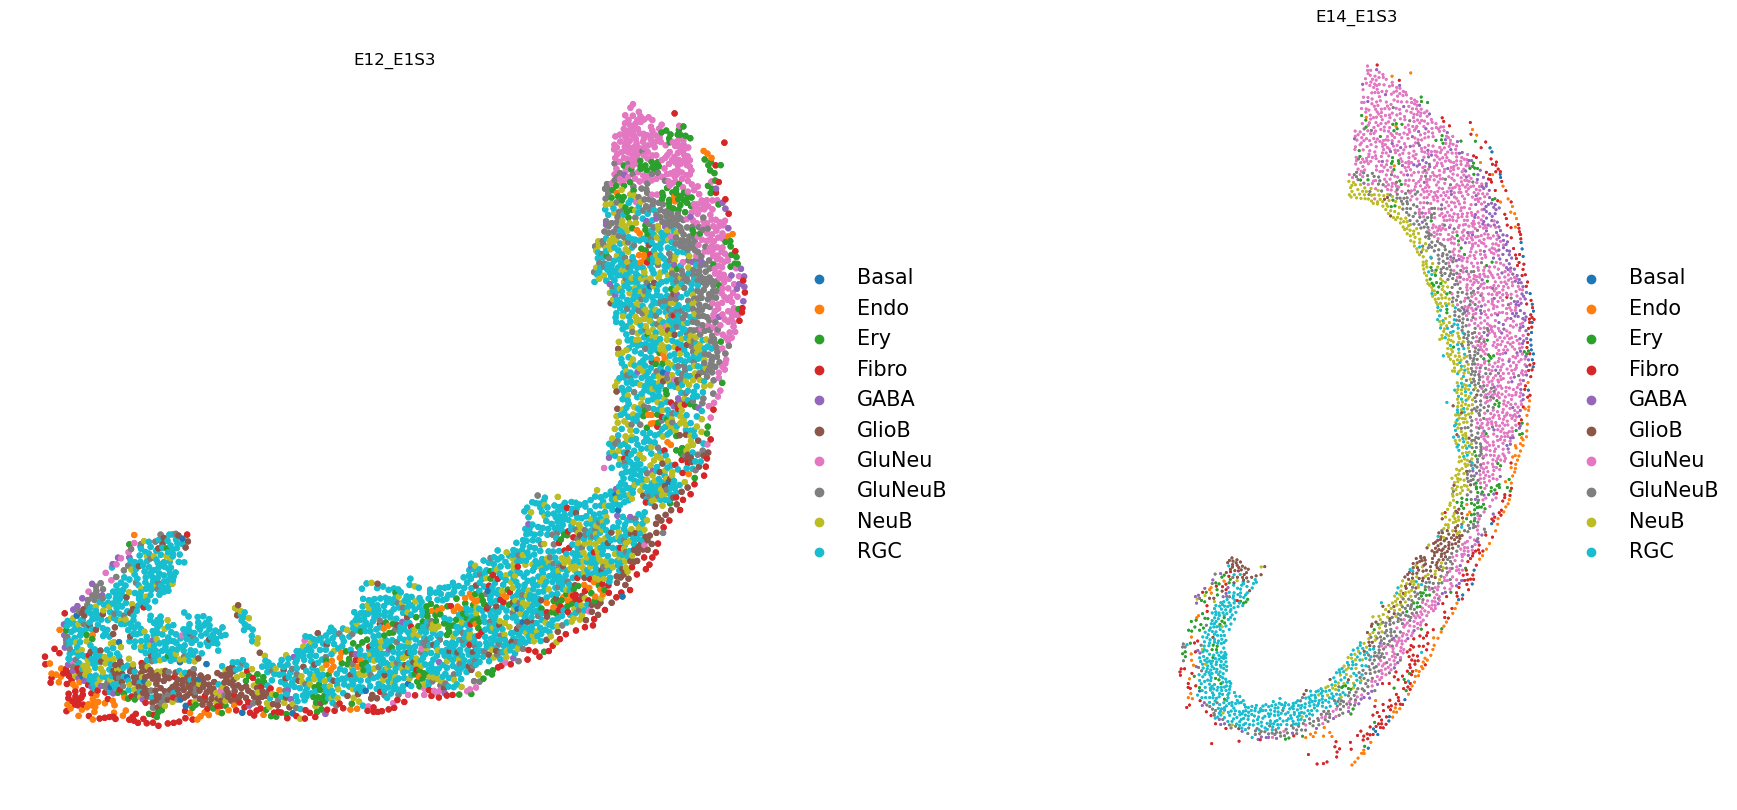

In [5]:
import warnings
warnings.filterwarnings('ignore')


adata_e12_14.obs['time'] = pd.Categorical(adata_e12_14.obs['time'])
library_ids = list(adata_e12_14.obs["sample"].cat.categories)
sq.pl.spatial_scatter(
    adata_e12_14,
    color="annot",
    frameon=False,
    shape=None,
    library_key="library_id",
    figsize=(10, 10),
    size=[50, 5],
    library_id=library_ids,
    title=library_ids,
    legend_fontsize=15,
)

In [6]:
sc.pp.normalize_total(adata_e12_14)
sc.pp.log1p(adata_e12_14)
sc.pp.pca(adata_e12_14)
sc.pp.neighbors(adata_e12_14)
sc.tl.umap(adata_e12_14)
sc.tl.leiden(adata_e12_14)

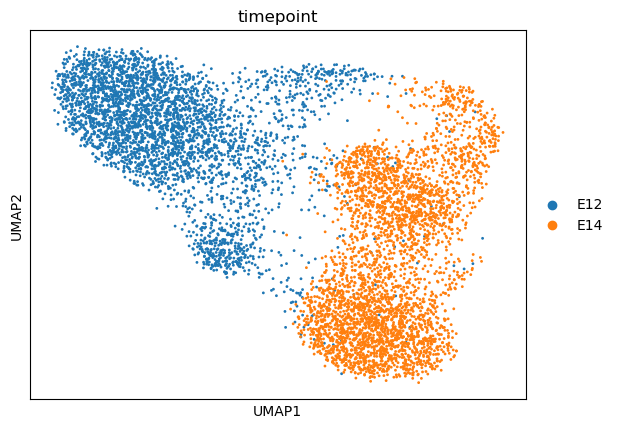

In [7]:
import warnings
warnings.filterwarnings('ignore')

sc.pl.umap(adata_e12_14, color='timepoint')

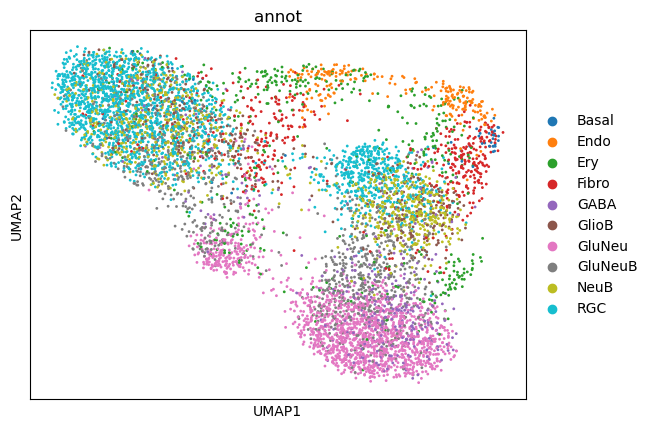

In [8]:
import warnings
warnings.filterwarnings('ignore')

sc.pl.umap(adata_e12_14,color='annot')

In [9]:
# initialize the SpatialTemporalProblem
stp_e12_14 = SpatioTemporalProblem(adata_e12_14)
stp_e12_14

SpatioTemporalProblem[]

In [10]:
# marginals
stp_e12_14 = stp_e12_14.score_genes_for_marginals(
    gene_set_proliferation="mouse", gene_set_apoptosis="mouse"
)

In [11]:
import warnings
warnings.filterwarnings('ignore')

# prepare the stp problem
# time_key has to be numeric
stp_e12_14 = stp_e12_14.prepare(
    time_key="time",
    spatial_key="spatial",
    joint_attr=None,
    callback="local-pca",
)

INFO     Ordering Index(['E12_E1S3_100034', 'E12_E1S3_100035', 'E12_E1S3_100191',                                  
                'E12_E1S3_100256', 'E12_E1S3_100264', 'E12_E1S3_100337',                                           
                'E12_E1S3_100346', 'E12_E1S3_100461', 'E12_E1S3_100502',                                           
                'E12_E1S3_100532',                                                                                 
                ...                                                                                                
                'E14_E1S3_181832', 'E14_E1S3_181833', 'E14_E1S3_181835',                                           
                'E14_E1S3_181837', 'E14_E1S3_181838', 'E14_E1S3_181839',                                           
                'E14_E1S3_181840', 'E14_E1S3_181841', 'E14_E1S3_181842',                                           
                'E14_E1S3_181843'],                                     

In [12]:
# solve the problem
stp_e12_14 = stp_e12_14.solve(max_iterations=100)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(3679, 3664)].                                  
WARNING  Solver did not converge                                                                                   


In [13]:
# order annotations
celltypes_source_1 = adata_e12_14[adata_e12_14.obs["time"] == 12.5].obs["annot"].cat.categories
celltypes_target_1 = adata_e12_14[adata_e12_14.obs["time"] == 14.5].obs["annot"].cat.categories
celltypes_intersection_1 = list(
    set(celltypes_source_1).intersection(celltypes_target_1)
)
source_ordered_1 = celltypes_intersection_1 + list(
    set(celltypes_source_1) - set(celltypes_target_1)
)
target_ordered_1 = celltypes_intersection_1 + list(
    set(celltypes_target_1) - set(celltypes_source_1)
)
print (source_ordered_1)
print (target_ordered_1)

['GluNeu', 'GABA', 'NeuB', 'Ery', 'Endo', 'GlioB', 'RGC', 'Fibro', 'Basal', 'GluNeuB']
['GluNeu', 'GABA', 'NeuB', 'Ery', 'Endo', 'GlioB', 'RGC', 'Fibro', 'Basal', 'GluNeuB']


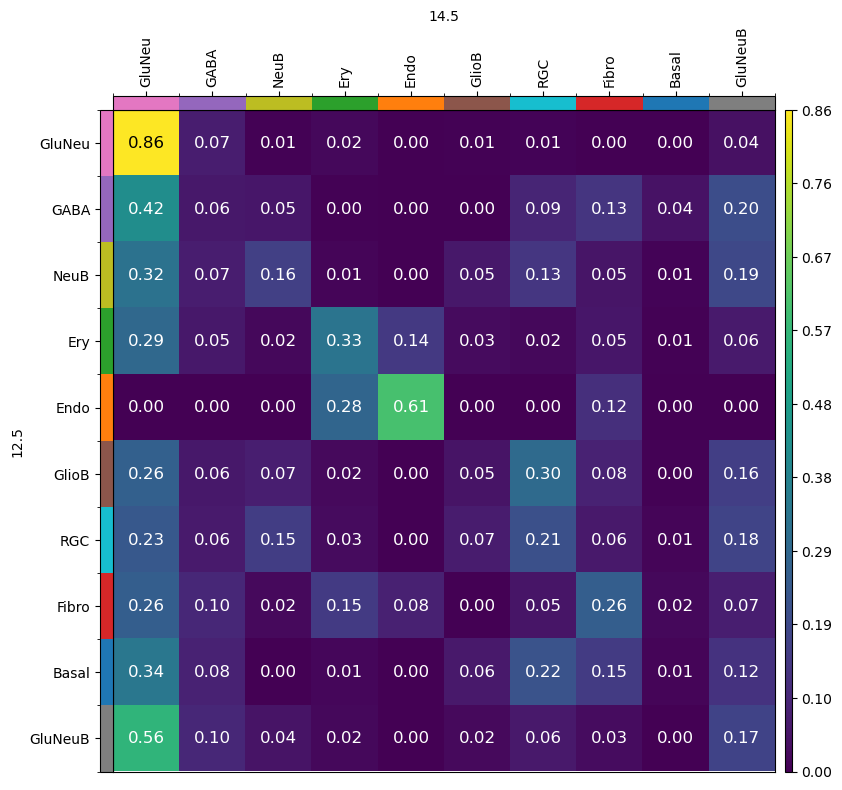

In [14]:
import warnings
warnings.filterwarnings('ignore')

# see which cell type is matched to which cell type across time: E12.5 -> E14.5
stp_e12_14.cell_transition(
    source=12.5,
    target=14.5,
    source_groups={"annot": source_ordered_1},
    target_groups={"annot": target_ordered_1},
    forward=True,
)
mtp.cell_transition(stp_e12_14, fontsize=12, figsize=(7, 7))

In [15]:
stp_e12_14.problems

{(12.5, 14.5): BirthDeathProblem[stage='solved', shape=(3679, 3664)]}

In [16]:
# push cells from E12.5 to E14.5
for i in set(adata_e12_14.obs['annot'].cat.categories):
    for (start, end), prob in stp_e12_14.problems.items():
        stp_e12_14.push(
        source=start,
        target=end,
        data="annot",
        subset=str(i),
        key_added=str(i) + "_mapping"
        )
    #adata_e12_14.obs[str(i)+'_annotation'] = [str(i) if value == i else 'rest' for value in adata_e12_14.obs['annot'].values]

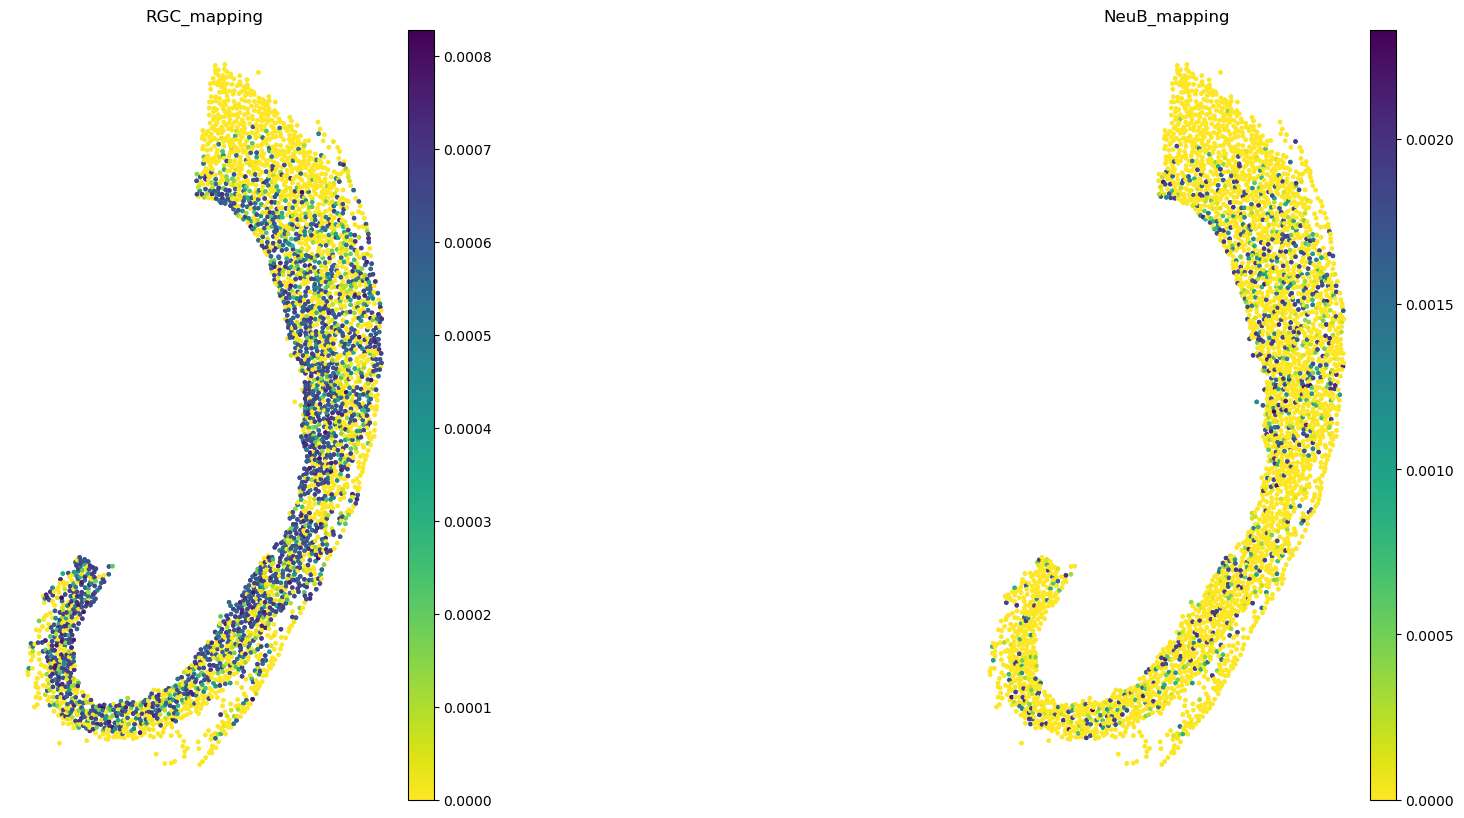

In [17]:
import warnings
warnings.filterwarnings('ignore')

sq.pl.spatial_scatter(
    adata_e12_14,
    color=["RGC_mapping","NeuB_mapping"],
    frameon=False,
    shape=None,
    library_key="library_id",
    library_id='E14_E1S3',
    cmap="viridis_r",
    figsize=(10, 10),
    size=[20],
    legend_fontsize=15
)

In [24]:
adata_e12_14.obs.shape

(7343, 32)

In [29]:
adata_e12_14.obs.columns

Index(['orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'sample',
       'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters',
       'SCT_snn_res.0.8', 'annot', 'nCount_Niche', 'nFeature_Niche',
       'annot_niche_max', 'timepoint', 'dpt_sct', 'AP', 'DV', 'library_id',
       'time', 'leiden', 'proliferation', 'apoptosis', 'GluNeu_mapping',
       'GABA_mapping', 'NeuB_mapping', 'Ery_mapping', 'Endo_mapping',
       'GlioB_mapping', 'RGC_mapping', 'Fibro_mapping', 'Basal_mapping',
       'GluNeuB_mapping'],
      dtype='object')

In [33]:
adata_e12_14.obs.index

Index(['E12_E1S3_100034', 'E12_E1S3_100035', 'E12_E1S3_100191',
       'E12_E1S3_100256', 'E12_E1S3_100264', 'E12_E1S3_100337',
       'E12_E1S3_100346', 'E12_E1S3_100461', 'E12_E1S3_100502',
       'E12_E1S3_100532',
       ...
       'E14_E1S3_181832', 'E14_E1S3_181833', 'E14_E1S3_181835',
       'E14_E1S3_181837', 'E14_E1S3_181838', 'E14_E1S3_181839',
       'E14_E1S3_181840', 'E14_E1S3_181841', 'E14_E1S3_181842',
       'E14_E1S3_181843'],
      dtype='object', length=7343)

In [31]:
adata_e12_14.obs['orig.ident'].value_counts()

orig.ident
E12    3679
E14    3664
Name: count, dtype: int64

In [32]:
stp_e12_14.solutions[12.5,14.5].transport_matrix.shape

(3679, 3664)

In [27]:
sum(stp_e12_14.solutions[12.5,14.5].transport_matrix.shape)

7343

In [37]:
adata_e12_14.obs.to_csv('adata_e12_e14_moscotMeta.csv')

# pd.DataFrame(np.asarray(stp_e12_14.solutions[12.5,14.5].transport_matrix, dtype=float)).to_csv('E12_E14_cm.csv')
transition_matrix_df = pd.DataFrame(np.asarray(stp_e12_14.solutions[12.5,14.5].transport_matrix, dtype=float))
transition_matrix_df.index = adata_e12_14.obs.index[adata_e12_14.obs['orig.ident'] == 'E12']
transition_matrix_df.columns = adata_e12_14.obs.index[adata_e12_14.obs['orig.ident'] == 'E14']
transition_matrix_df.to_csv('E12_E14_cm.csv')

# E14.5 -> E16.5

## E16_E1S3

In [38]:
samples = ['E14_E1S3','E16_E1S3']
adata_list = []
for i in samples:
    counts = pd.read_csv('../../../source/Moscot/ss0_'+str(i)+'_GEraw.csv',index_col=0)
    coords = pd.read_csv('../../../source/Moscot/ss0_'+str(i)+'_loc.csv',index_col=0)
    meta = pd.read_csv('../../../source/Moscot/ss0_'+str(i)+'_meta.csv',index_col=0)
    adata = sc.AnnData(X = counts, obs = meta, obsm = {'spatial': coords.to_numpy()})
    adata.layers['counts'] = adata.X
    adata.obs['sample'] = pd.Categorical(adata.obs['sample'])
    adata_list.append(adata)

In [40]:
adata_e14_16_1 = ad.concat(
    {"E14_E1S3": adata_list[0], "E16_E1S3": adata_list[1]},
    label="library_id"
)
timepoint = [float(item.split('E')[1])+0.5 for item in adata_e14_16_1.obs.timepoint.values]
adata_e14_16_1.obs['time'] = timepoint
adata_e14_16_1.obs['time'] = pd.Categorical(adata_e14_16_1.obs['time'])
adata_e14_16_1.obs['time'].value_counts()

time
16.5    6643
14.5    3664
Name: count, dtype: int64

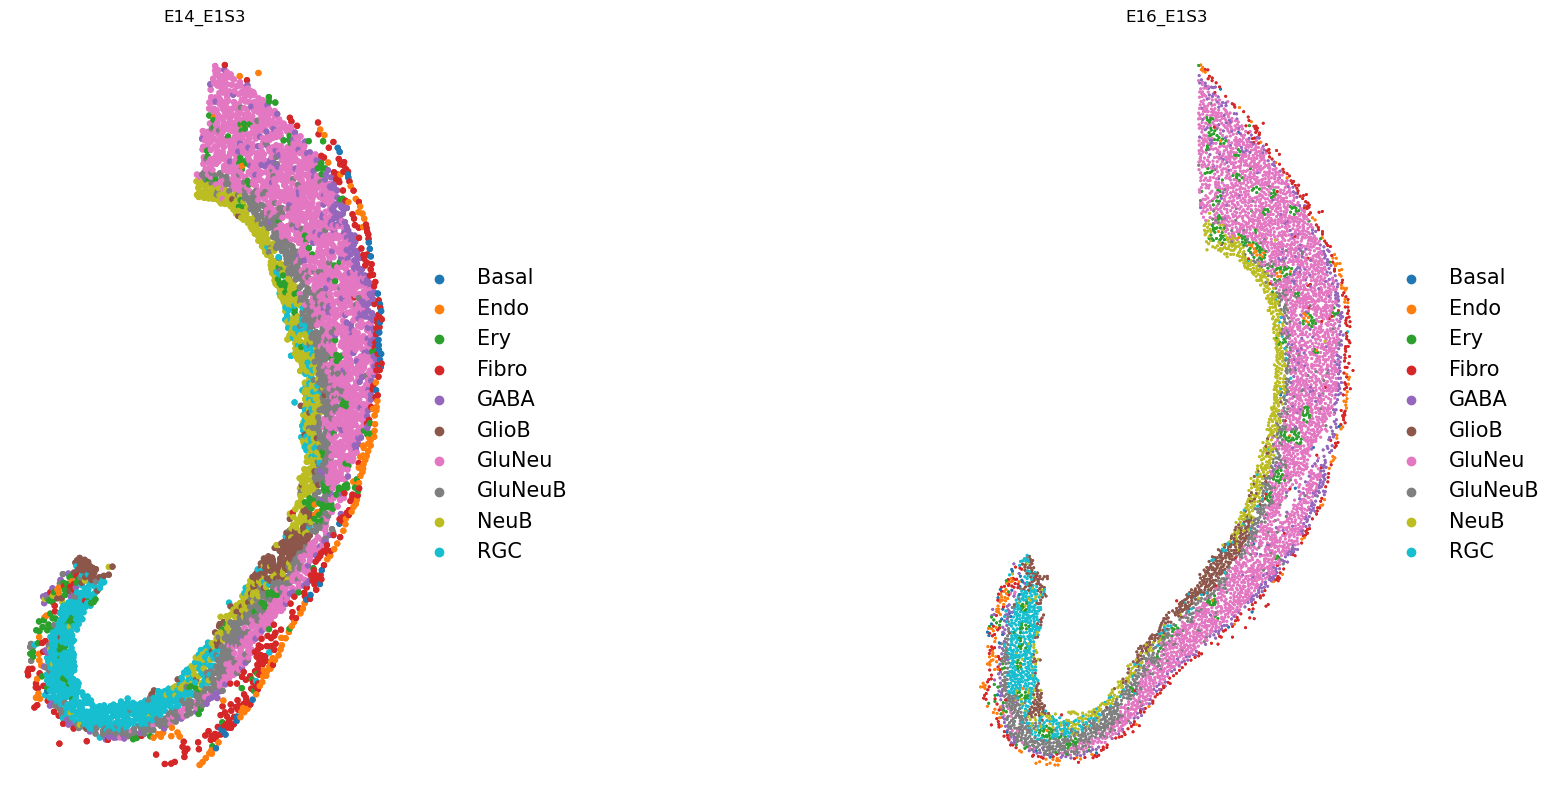

In [41]:
import warnings
warnings.filterwarnings('ignore')

library_ids = list(adata_e14_16_1.obs["sample"].astype('category').cat.categories)
sq.pl.spatial_scatter(
    adata_e14_16_1,
    color="annot",
    frameon=False,
    shape=None,
    library_key="library_id",
    figsize=(10, 10),
    size=[50, 5],
    library_id=library_ids,
    title=library_ids,
    legend_fontsize=15,
)

In [42]:
sc.pp.normalize_total(adata_e14_16_1)
sc.pp.log1p(adata_e14_16_1)
sc.pp.pca(adata_e14_16_1)
sc.pp.neighbors(adata_e14_16_1)
sc.tl.umap(adata_e14_16_1)
sc.tl.leiden(adata_e14_16_1)

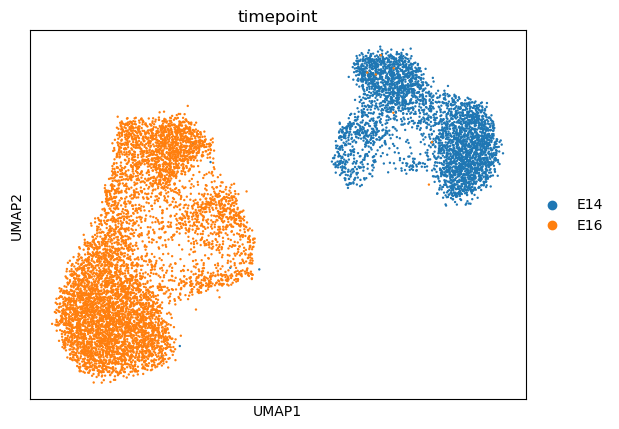

In [43]:
import warnings
warnings.filterwarnings('ignore')

sc.pl.umap(adata_e14_16_1, color='timepoint')

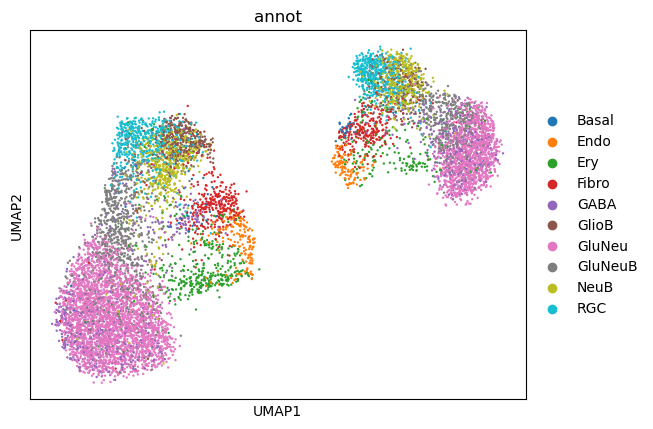

In [44]:
import warnings
warnings.filterwarnings('ignore')

sc.pl.umap(adata_e14_16_1, color='annot')

In [45]:
# initialize the SpatialTemporalProblem
stp_e14_16_1 = SpatioTemporalProblem(adata_e14_16_1)
# marginals
stp_e14_16_1 = stp_e14_16_1.score_genes_for_marginals(
    gene_set_proliferation="mouse", gene_set_apoptosis="mouse"
)

In [46]:
import warnings
warnings.filterwarnings('ignore')

# prepare the stp problem
# time_key has to be numeric
stp_e14_16_1 = stp_e14_16_1.prepare(
    time_key="time",
    spatial_key="spatial",
    joint_attr=None,
    callback="local-pca",
)

INFO     Ordering Index(['E14_E1S3_170808', 'E14_E1S3_170916', 'E14_E1S3_170934',                                  
                'E14_E1S3_171016', 'E14_E1S3_171024', 'E14_E1S3_171025',                                           
                'E14_E1S3_171102', 'E14_E1S3_171143', 'E14_E1S3_171161',                                           
                'E14_E1S3_171233',                                                                                 
                ...                                                                                                
                'E16_E1S3_6920', 'E16_E1S3_6921', 'E16_E1S3_6923', 'E16_E1S3_6924',                                
                'E16_E1S3_6925', 'E16_E1S3_6926', 'E16_E1S3_6928', 'E16_E1S3_6929',                                
                'E16_E1S3_6930', 'E16_E1S3_6931'],                                                                 
               dtype='object', length=10307) in ascending order.        

In [47]:
# solve the problem
stp_e14_16_1 = stp_e14_16_1.solve()

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(3664, 6643)].                                  
WARNING  Solver did not converge                                                                                   


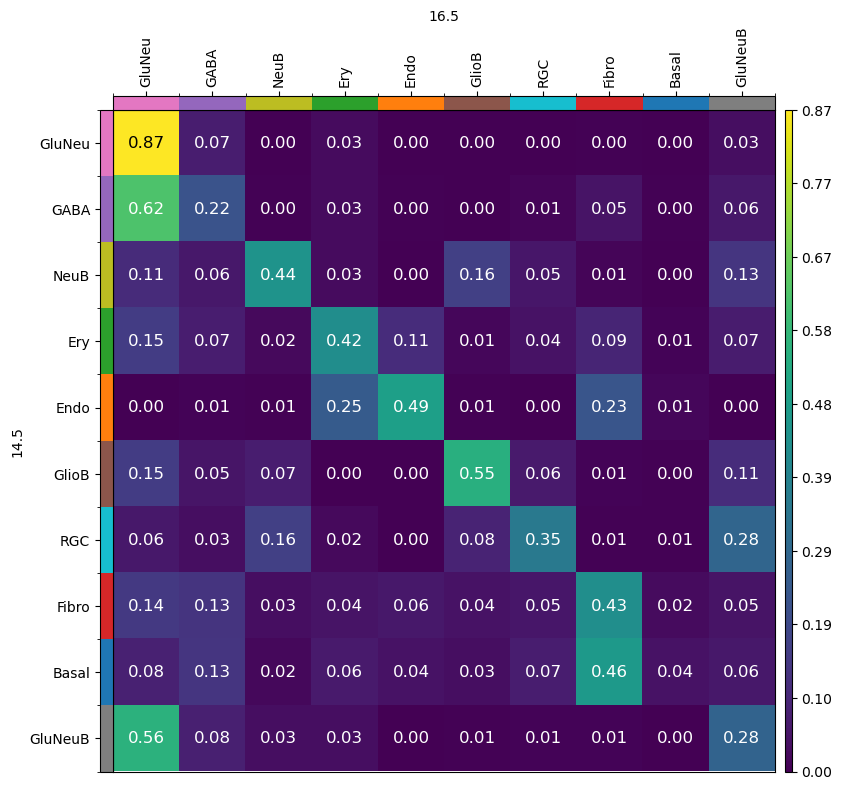

In [48]:
import warnings
warnings.filterwarnings('ignore')

# order annotations
celltypes_source_1 = adata_e14_16_1[adata_e14_16_1.obs["time"] == 14.5].obs["annot"].cat.categories
celltypes_target_1 = adata_e14_16_1[adata_e14_16_1.obs["time"] == 16.5].obs["annot"].cat.categories
celltypes_intersection_1 = list(
    set(celltypes_source_1).intersection(celltypes_target_1)
)
source_ordered_1 = celltypes_intersection_1 + list(
    set(celltypes_source_1) - set(celltypes_target_1)
)
target_ordered_1 = celltypes_intersection_1 + list(
    set(celltypes_target_1) - set(celltypes_source_1)
)

# see which cell type is matched to which cell type across time: E12.5 -> E14.5
stp_e14_16_1.cell_transition(
    source=14.5,
    target=16.5,
    source_groups={"annot": source_ordered_1},
    target_groups={"annot": target_ordered_1},
    forward=True,
)
mtp.cell_transition(stp_e14_16_1, fontsize=12, figsize=(7, 7))

In [49]:
for i in set(adata_e14_16_1.obs['annot'].cat.categories):
    for (start, end), prob in stp_e14_16_1.problems.items():
        stp_e14_16_1.push(
        source=start,
        target=end,
        data="annot",
        subset=str(i),
        key_added=str(i) + "_mapping"
        )

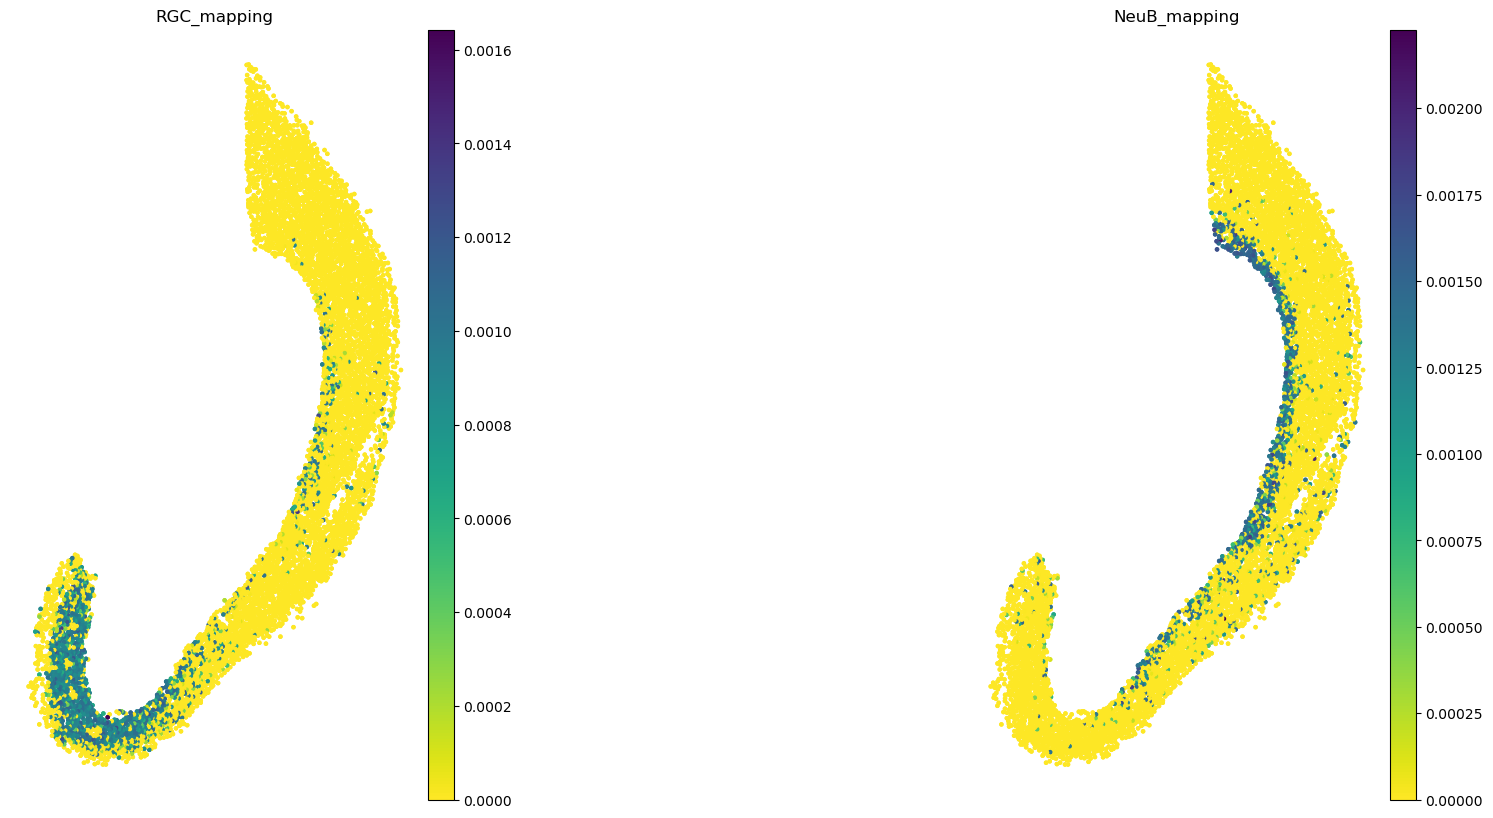

In [50]:
import warnings
warnings.filterwarnings('ignore')

sq.pl.spatial_scatter(
    adata_e14_16_1,
    color=["RGC_mapping","NeuB_mapping"],
    frameon=False,
    shape=None,
    library_key="library_id",
    library_id='E16_E1S3',
    cmap="viridis_r",
    figsize=(10, 10),
    size=[20],
    legend_fontsize=15
)

In [51]:
adata_e14_16_1.obs.to_csv('adata_e14_e16_1_moscotMeta.csv')

In [54]:
#pd.DataFrame(np.asarray(stp_e14_16_1.solutions[14.5,16.5].transport_matrix, dtype=float)).to_csv('E14_E16_1_cm.csv')
transition_matrix_df = pd.DataFrame(np.asarray(stp_e14_16_1.solutions[14.5,16.5].transport_matrix, dtype=float))
transition_matrix_df.index = adata_e14_16_1.obs.index[adata_e14_16_1.obs['orig.ident'] == 'E14']
transition_matrix_df.columns = adata_e14_16_1.obs.index[adata_e14_16_1.obs['orig.ident'] == 'E16']
transition_matrix_df.to_csv('E14_E16_1_cm.csv')


## E16_E2S6

In [71]:
samples = ['E14_E1S3','E16_E2S6']
adata_list = []
for i in samples:
    counts = pd.read_csv('../../../source/Moscot/ss0_'+str(i)+'_GEraw.csv',index_col=0)
    coords = pd.read_csv('../../../source/Moscot/ss0_'+str(i)+'_loc.csv',index_col=0)
    meta = pd.read_csv('../../../source/Moscot/ss0_'+str(i)+'_meta.csv',index_col=0)
    adata = sc.AnnData(X = counts, obs = meta, obsm = {'spatial': coords.to_numpy()})
    adata.layers['counts'] = adata.X
    adata.obs['sample'] = pd.Categorical(adata.obs['sample'])
    adata_list.append(adata)

In [72]:
adata_e14_16_2 = ad.concat(
    {samples[0]: adata_list[0], samples[1]: adata_list[1]},
    label="library_id"
)
timepoint = [float(item.split('E')[1])+0.5 for item in adata_e14_16_2.obs.timepoint.values]
adata_e14_16_2.obs['time'] = timepoint
adata_e14_16_2.obs['time'] = pd.Categorical(adata_e14_16_2.obs['time'])
adata_e14_16_2.obs['time'].value_counts()

time
16.5    5506
14.5    3664
Name: count, dtype: int64

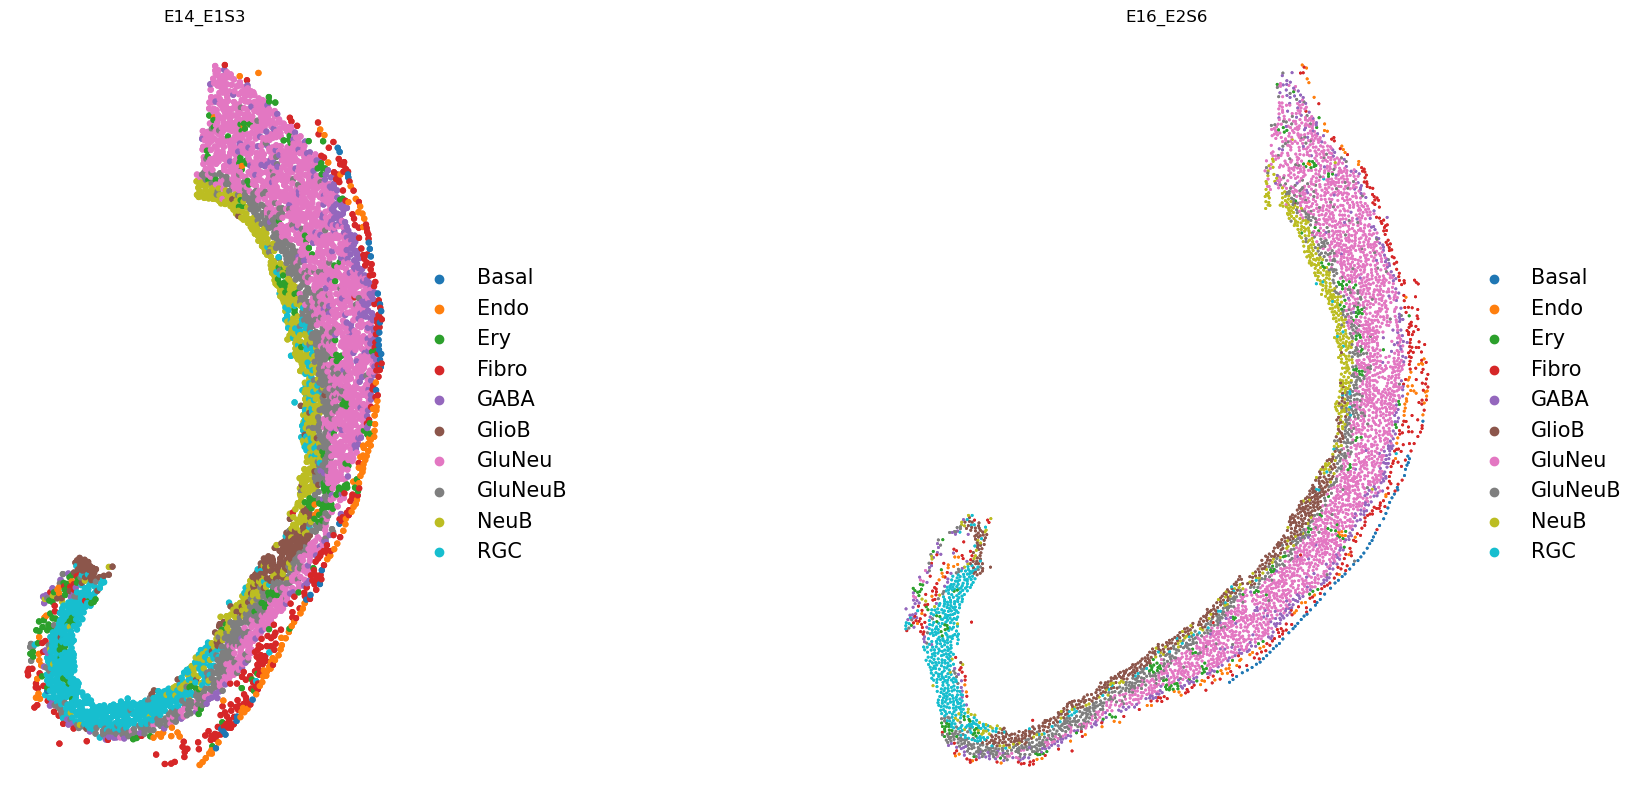

In [73]:
import warnings
warnings.filterwarnings('ignore')

library_ids = list(adata_e14_16_2.obs["sample"].astype('category').cat.categories)
sq.pl.spatial_scatter(
    adata_e14_16_2,
    color="annot",
    frameon=False,
    shape=None,
    library_key="library_id",
    figsize=(10, 10),
    size=[50, 5],
    library_id=library_ids,
    title=library_ids,
    legend_fontsize=15,
)

In [74]:
sc.pp.normalize_total(adata_e14_16_2)
sc.pp.log1p(adata_e14_16_2)
sc.pp.pca(adata_e14_16_2)
sc.pp.neighbors(adata_e14_16_2)
sc.tl.umap(adata_e14_16_2)
sc.tl.leiden(adata_e14_16_2)

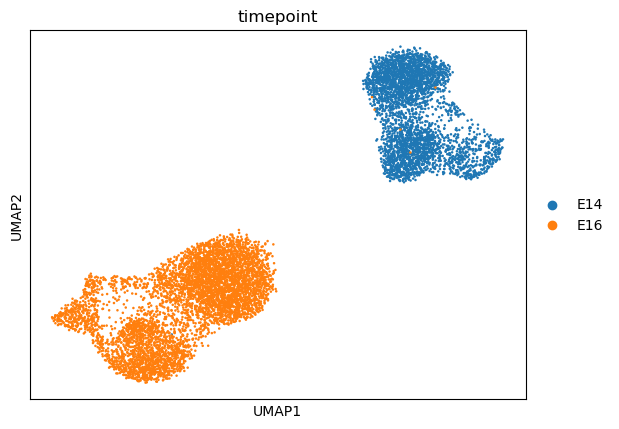

In [75]:
import warnings
warnings.filterwarnings('ignore')

sc.pl.umap(adata_e14_16_2, color='timepoint')

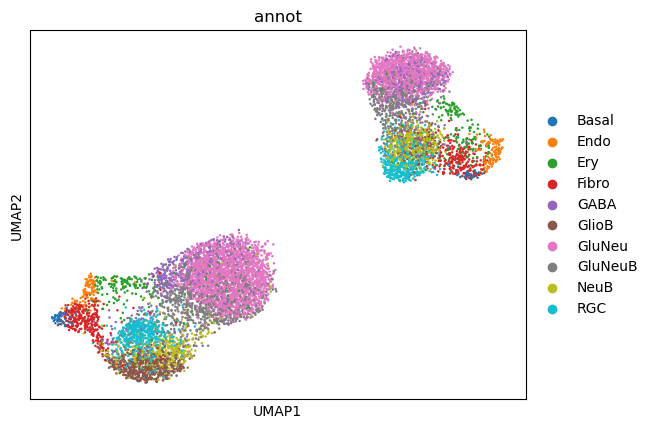

In [76]:
import warnings
warnings.filterwarnings('ignore')

sc.pl.umap(adata_e14_16_2, color='annot')

In [77]:
# initialize the SpatialTemporalProblem
stp_e14_16_2 = SpatioTemporalProblem(adata_e14_16_2)
# marginals
stp_e14_16_2 = stp_e14_16_2.score_genes_for_marginals(
    gene_set_proliferation="mouse", gene_set_apoptosis="mouse"
)

In [78]:
import warnings
warnings.filterwarnings('ignore')

# prepare the stp problem
# time_key has to be numeric
stp_e14_16_2 = stp_e14_16_2.prepare(
    time_key="time",
    spatial_key="spatial",
    joint_attr=None,
    callback="local-pca",
)

INFO     Ordering Index(['E14_E1S3_170808', 'E14_E1S3_170916', 'E14_E1S3_170934',                                  
                'E14_E1S3_171016', 'E14_E1S3_171024', 'E14_E1S3_171025',                                           
                'E14_E1S3_171102', 'E14_E1S3_171143', 'E14_E1S3_171161',                                           
                'E14_E1S3_171233',                                                                                 
                ...                                                                                                
                'E16_E2S6_36290', 'E16_E2S6_36348', 'E16_E2S6_36407', 'E16_E2S6_36523',                            
                'E16_E2S6_36607', 'E16_E2S6_36632', 'E16_E2S6_36755', 'E16_E2S6_36782',                            
                'E16_E2S6_36838', 'E16_E2S6_36891'],                                                               
               dtype='object', length=9170) in ascending order.         

In [79]:
# solve the problem
stp_e14_16_2 = stp_e14_16_2.solve()

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(3664, 5506)].                                  
WARNING  Solver did not converge                                                                                   


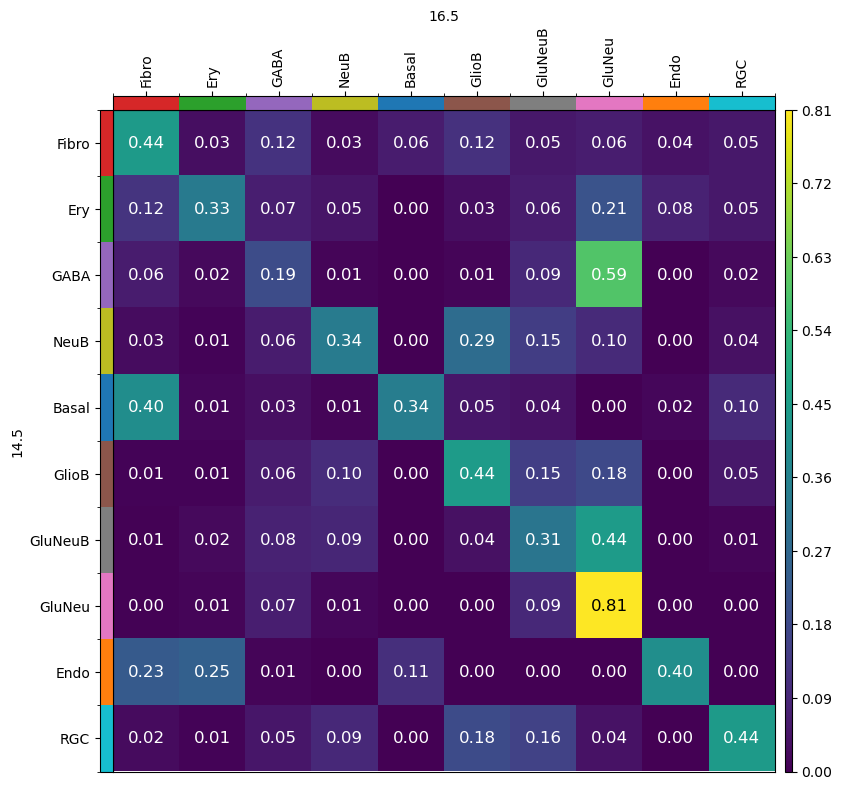

In [80]:
import warnings
warnings.filterwarnings('ignore')

# order annotations
celltypes_source_1 = adata_e14_16_2[adata_e14_16_2.obs["time"] == 14.5].obs["annot"].cat.categories
celltypes_target_1 = adata_e14_16_2[adata_e14_16_2.obs["time"] == 16.5].obs["annot"].cat.categories
celltypes_intersection_1 = list(
    set(celltypes_source_1).intersection(celltypes_target_1)
)
source_ordered_1 = celltypes_intersection_1 + list(
    set(celltypes_source_1) - set(celltypes_target_1)
)
target_ordered_1 = celltypes_intersection_1 + list(
    set(celltypes_target_1) - set(celltypes_source_1)
)

# see which cell type is matched to which cell type across time: E12.5 -> E14.5
stp_e14_16_2.cell_transition(
    source=14.5,
    target=16.5,
    source_groups={"annot": source_ordered_1},
    target_groups={"annot": target_ordered_1},
    forward=True,
)
mtp.cell_transition(stp_e14_16_2, fontsize=12, figsize=(7, 7))

In [81]:
for i in set(adata_e14_16_2.obs['annot'].cat.categories):
    for (start, end), prob in stp_e14_16_2.problems.items():
        stp_e14_16_2.push(
        source=start,
        target=end,
        data="annot",
        subset=str(i),
        key_added=str(i) + "_mapping"
        )

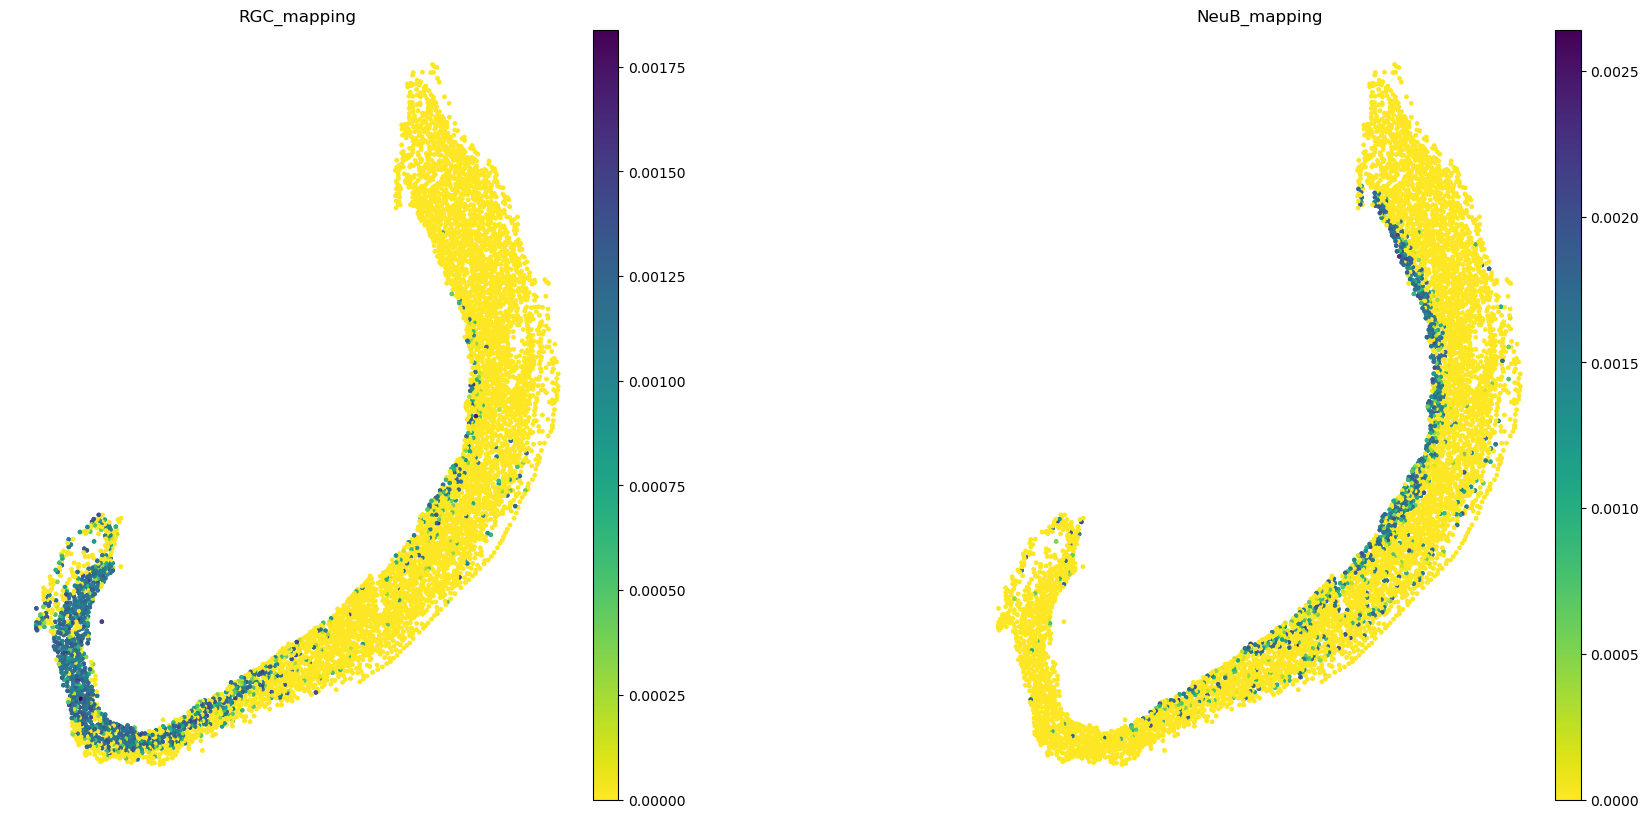

In [83]:
import warnings
warnings.filterwarnings('ignore')

sq.pl.spatial_scatter(
    adata_e14_16_2,
    color=["RGC_mapping","NeuB_mapping"],
    frameon=False,
    shape=None,
    library_key="library_id",
    library_id=samples[1],
    cmap="viridis_r",
    figsize=(10, 10),
    size=[20],
    legend_fontsize=15
)

In [84]:
adata_e14_16_2.obs.to_csv('adata_e14_e16_2_moscotMeta.csv')

In [85]:
pd.DataFrame(np.asarray(stp_e14_16_2.solutions[14.5,16.5].transport_matrix, dtype=float)).to_csv('E14_E16_2_cm.csv')

## E16_E2S7

In [86]:
samples = ['E14_E1S3','E16_E2S7']
adata_list = []
for i in samples:
    counts = pd.read_csv('../../../source/Moscot/ss0_'+str(i)+'_GEraw.csv',index_col=0)
    coords = pd.read_csv('../../../source/Moscot/ss0_'+str(i)+'_loc.csv',index_col=0)
    meta = pd.read_csv('../../../source/Moscot/ss0_'+str(i)+'_meta.csv',index_col=0)
    adata = sc.AnnData(X = counts, obs = meta, obsm = {'spatial': coords.to_numpy()})
    adata.layers['counts'] = adata.X
    adata.obs['sample'] = pd.Categorical(adata.obs['sample'])
    adata_list.append(adata)

In [87]:
adata_e14_16_3 = ad.concat(
    {samples[0]: adata_list[0], samples[1]: adata_list[1]},
    label="library_id"
)
timepoint = [float(item.split('E')[1])+0.5 for item in adata_e14_16_3.obs.timepoint.values]
adata_e14_16_3.obs['time'] = timepoint
adata_e14_16_3.obs['time'] = pd.Categorical(adata_e14_16_3.obs['time'])
adata_e14_16_3.obs['time'].value_counts()

time
16.5    7261
14.5    3664
Name: count, dtype: int64

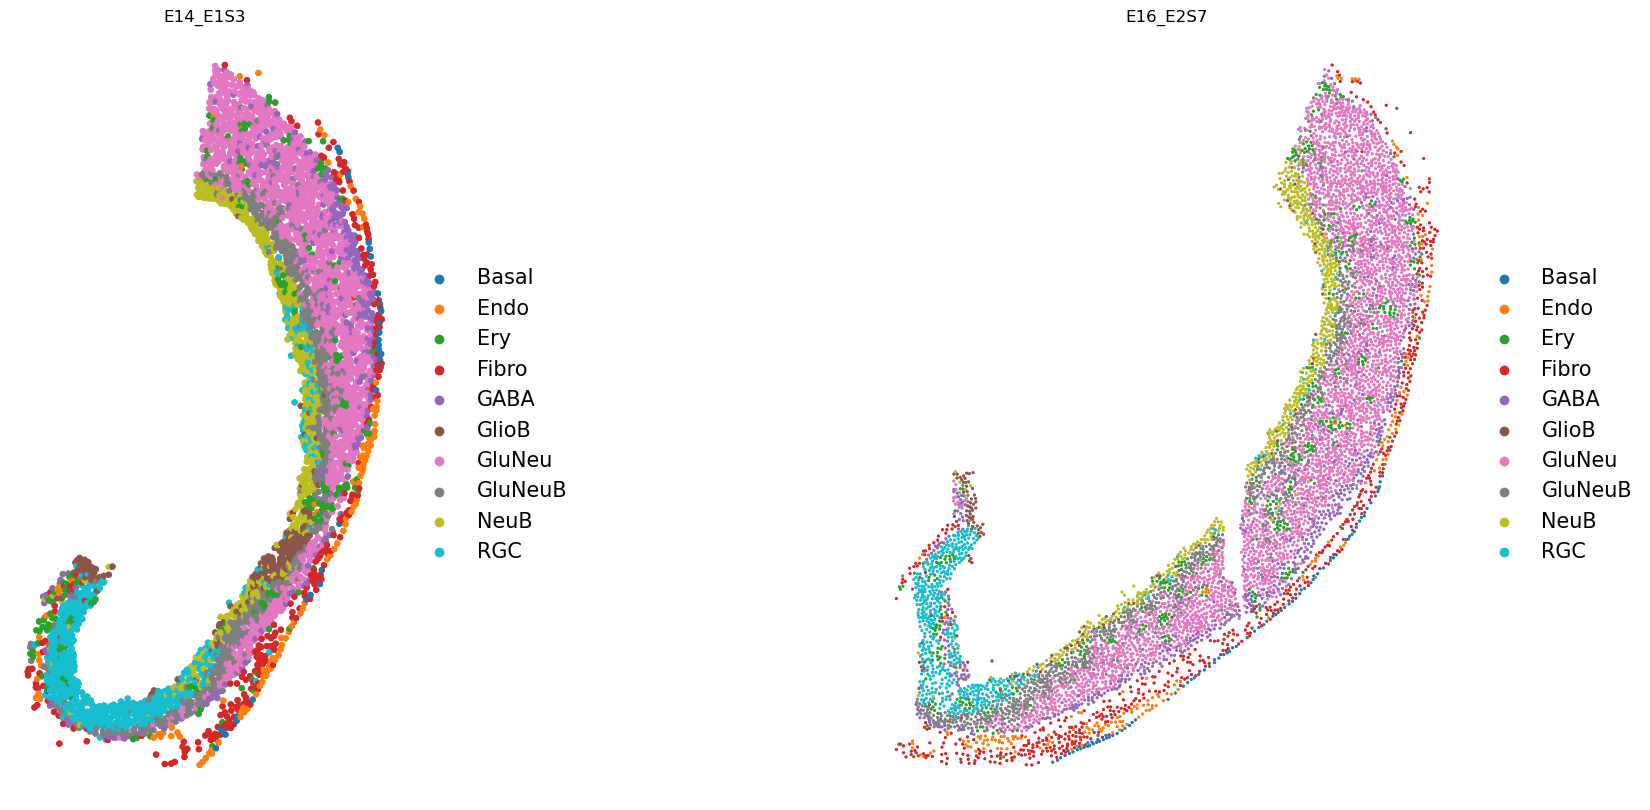

In [88]:
import warnings
warnings.filterwarnings('ignore')

library_ids = list(adata_e14_16_3.obs["sample"].astype('category').cat.categories)
sq.pl.spatial_scatter(
    adata_e14_16_3,
    color="annot",
    frameon=False,
    shape=None,
    library_key="library_id",
    figsize=(10, 10),
    size=[50, 5],
    library_id=library_ids,
    title=library_ids,
    legend_fontsize=15,
)

In [89]:
sc.pp.normalize_total(adata_e14_16_3)
sc.pp.log1p(adata_e14_16_3)
sc.pp.pca(adata_e14_16_3)
sc.pp.neighbors(adata_e14_16_3)
sc.tl.umap(adata_e14_16_3)
sc.tl.leiden(adata_e14_16_3)

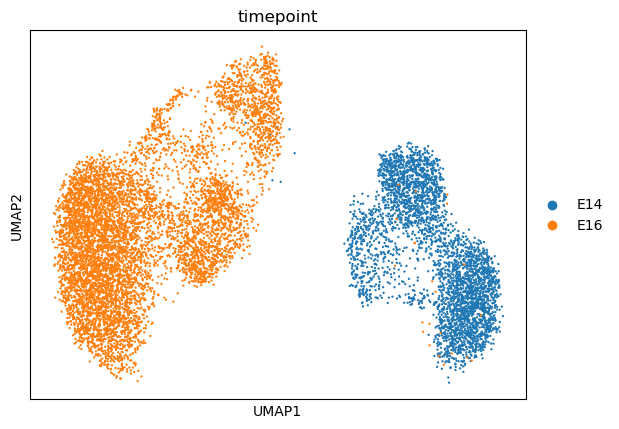

In [90]:
import warnings
warnings.filterwarnings('ignore')

sc.pl.umap(adata_e14_16_3, color='timepoint')

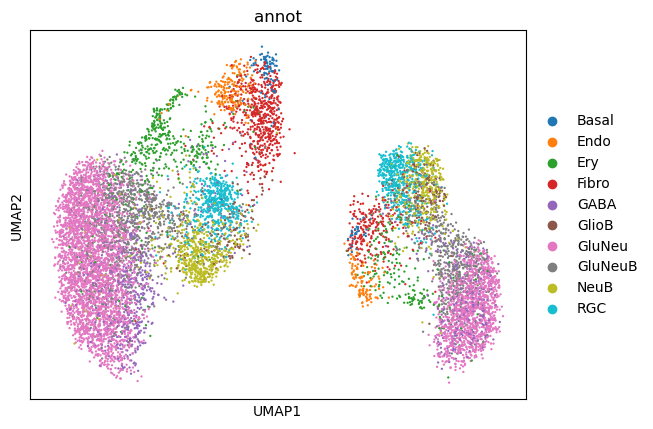

In [91]:
import warnings
warnings.filterwarnings('ignore')

sc.pl.umap(adata_e14_16_3, color='annot')

In [92]:
# initialize the SpatialTemporalProblem
stp_e14_16_3 = SpatioTemporalProblem(adata_e14_16_3)
# marginals
stp_e14_16_3 = stp_e14_16_3.score_genes_for_marginals(
    gene_set_proliferation="mouse", gene_set_apoptosis="mouse"
)

In [93]:
import warnings
warnings.filterwarnings('ignore')

# prepare the stp problem
# time_key has to be numeric
stp_e14_16_3 = stp_e14_16_3.prepare(
    time_key="time",
    spatial_key="spatial",
    joint_attr=None,
    callback="local-pca",
)

INFO     Ordering Index(['E14_E1S3_170808', 'E14_E1S3_170916', 'E14_E1S3_170934',                                  
                'E14_E1S3_171016', 'E14_E1S3_171024', 'E14_E1S3_171025',                                           
                'E14_E1S3_171102', 'E14_E1S3_171143', 'E14_E1S3_171161',                                           
                'E14_E1S3_171233',                                                                                 
                ...                                                                                                
                'E16_E2S7_326320', 'E16_E2S7_326323', 'E16_E2S7_326324',                                           
                'E16_E2S7_326325', 'E16_E2S7_326329', 'E16_E2S7_326357',                                           
                'E16_E2S7_326359', 'E16_E2S7_326384', 'E16_E2S7_326391',                                           
                'E16_E2S7_326412'],                                     

In [ ]:
# solve the problem
stp_e14_16_3 = stp_e14_16_3.solve()

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(3664, 7261)].                                  


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# order annotations
celltypes_source_1 = adata_e14_16_3[adata_e14_16_3.obs["time"] == 14.5].obs["annot"].cat.categories
celltypes_target_1 = adata_e14_16_3[adata_e14_16_3.obs["time"] == 16.5].obs["annot"].cat.categories
celltypes_intersection_1 = list(
    set(celltypes_source_1).intersection(celltypes_target_1)
)
source_ordered_1 = celltypes_intersection_1 + list(
    set(celltypes_source_1) - set(celltypes_target_1)
)
target_ordered_1 = celltypes_intersection_1 + list(
    set(celltypes_target_1) - set(celltypes_source_1)
)

# see which cell type is matched to which cell type across time: E12.5 -> E14.5
stp_e14_16_3.cell_transition(
    source=14.5,
    target=16.5,
    source_groups={"annot": source_ordered_1},
    target_groups={"annot": target_ordered_1},
    forward=True,
)
mtp.cell_transition(stp_e14_16_3, fontsize=12, figsize=(7, 7))

In [ ]:
for i in set(adata_e14_16_3.obs['annot'].cat.categories):
    for (start, end), prob in stp_e14_16_3.problems.items():
        stp_e14_16_3.push(
        source=start,
        target=end,
        data="annot",
        subset=str(i),
        key_added=str(i) + "_mapping"
        )

In [ ]:
import warnings
warnings.filterwarnings('ignore')

sq.pl.spatial_scatter(
    adata_e14_16_3,
    color=["RGC_mapping","NeuB_mapping"],
    frameon=False,
    shape=None,
    library_key="library_id",
    library_id=samples[1],
    cmap="viridis_r",
    figsize=(10, 10),
    size=[20],
    legend_fontsize=15
)

In [ ]:
adata_e14_16_3.obs.to_csv('adata_e14_e16_3_moscotMeta.csv')

In [ ]:
pd.DataFrame(np.asarray(stp_e14_16_3.solutions[14.5,16.5].transport_matrix, dtype=float)).to_csv('E14_E16_3_cm.csv')